Hallo allemaal
Dit is mijn spreekbeurt over de hamster
Hij heet "Solving the convection-diffusion equation using upwind finite differences"
groetjes

This thing covers the take home exam blablabla

In [35]:
# setup problem parameters/functions
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
import sympy

def system_solver(N,e):
    # Initial values
    x= np.linspace(0,1,N)
    h=1/N
    
    # Constant values - Boundary conditions
    u0=1
    unp1=0
    
    # Discretisation
    A=scipy.sparse.diags([-e/h-1, 2*e/h+1, -e/h], [-1, 0, 1], shape=(N, N)).toarray()
    f=np.zeros(N)
    f[0]=e/h+1
    un=np.linalg.inv(A)@f
    return np.concatenate(([u0],un,[unp1])), A, f

def testfunc(N,e):
    x=np.linspace(0,1,N)
    return (np.exp(x/e)-np.exp(1/e))/(1-np.exp(1/e))

Problem 2

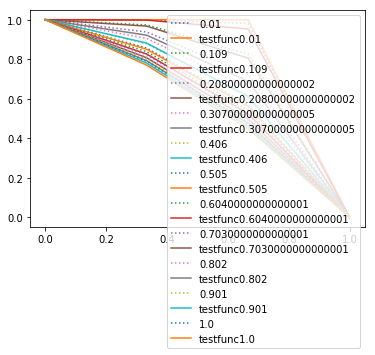

In [37]:
N=2
eps = np.linspace(1e-2,1,11)
for e in eps:
    plt.plot(np.linspace(0,1,N+2),system_solver(N,e)[0],label=str(e),ls='dotted')
    plt.plot(np.linspace(0,1,N+2),testfunc(N+2,e),label='testfunc'+str(e))
#    plt.plot(np.linspace(0,1,N+2),(testfunc(N+2,e)-system_solver(N,e)[0])/testfunc(N+2,e),label=str(e))
plt.legend()
plt.show()

Problem 2

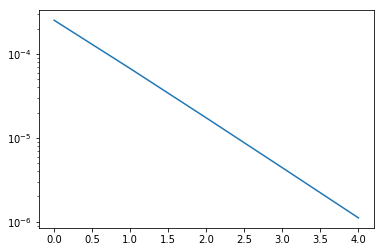

In [38]:
n=5
eps=0.5
error=[]
N_lst=[]
for i in range(4,n+4):
    N=2**i
    N_lst.append(N)
    un=system_solver(N,eps)
    error.append(max(np.abs(system_solver(N,eps)[0]-testfunc(N+2,eps))))    
#plt.plot(N_lst,error) # is not linear
plt.plot(range(5),error)
plt.yscale('log')

Problem 3

In [31]:
A=system_solver(10,0.5)[1]
np.allclose(A,A.T)
print(sympy.Matrix(A).rref())

(Matrix([
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]), (0, 1, 2, 3, 4, 5, 6, 7, 8, 9))


Problem 4